In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from amalearn.agent import AgentBase
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import RewardBase

# a , b

In [2]:
df = pd.read_csv('Q3.csv')
df.head(10)

,adidas 1,cost of adidas 1,adidas 2,cost of adidas 2,adidas 3,cost of adidas 3,Nike 1,cost of Nike 1,Nike 2,cost of Nike 2,Nike 3,cost of Nike 3
0,8.308075,0.118582,71.868439,4.032662,41.858863,10.259441,24.726454,15.071291,2.508992,19.966871,60.703456,22.545958
1,9.040232,1.276014,71.551909,4.893586,40.684587,9.183102,23.554125,14.188975,2.803275,19.766006,59.838882,22.771789
2,8.405164,2.573752,72.221606,5.201210,43.586272,10.972955,24.572589,14.177388,3.028663,20.104219,58.512739,22.247714
3,9.247704,1.375703,71.218781,4.120079,40.883604,10.480112,24.572818,15.133472,3.193420,20.347757,58.694852,22.659512
4,9.144098,-0.401791,71.275463,5.032439,40.145258,10.448089,23.401485,16.027929,3.466858,19.476062,59.009021,23.302446
5,7.579144,2.516067,71.645210,5.544848,43.035856,12.482435,25.905275,14.851727,2.951765,20.634357,59.998435,22.666912
6,9.233873,2.097313,72.358241,4.946655,41.482344,8.624057,23.926275,16.621825,3.118835,19.956610,61.177274,22.648880
7,8.297766,0.682235,72.886859,4.360855,40.009400,9.547419,24.901515,14.875132,3.073918,20.090735,60.348178,23.468323
8,8.303172,1.384924,72.404299,4.538784,41.728414,10.111804,25.072567,16.980442,3.087991,19.453882,59.232022,22.377940
9,8.594270,1.916078,71.757085,4.793329,40.766039,9.594373,24.641648,17.166800,2.855724,20.354084,60.528218,22.841973


In [3]:
df.shape

(498, 12)

In [4]:
def get_value(scores, costs):
    values = [((2 * score) - cost) for score, cost in zip(scores, costs)]
    means = [np.mean(value.to_numpy()) for value in values]
    #stds = [np.std(value.to_numpy()) for value in values]
    return values, means

In [5]:
scores = [df['adidas 1'],
          df['adidas 2'],
          df['adidas 3'],
          df['Nike 1'],
          df['Nike 2'],
          df['Nike 3']]

costs = [df['cost of adidas 1'],
         df['cost of adidas 2'],
         df['cost of adidas 3'],
         df['cost of Nike 1'],
         df['cost of Nike 2'],
         df['cost of Nike 3']]

values, means = get_value(scores, costs)
print("Mean of values: ",means)

Mean of values:  [15.652308044578314, 138.9716581196787, 72.87144628955822, 34.201771133734944, -14.123851261044178, 96.96925103012049]


In [6]:
class Reward(RewardBase):
    def __init__(self, value, mean):
        super(Reward, self).__init__()
        self.value = value
        self.mean = mean
        
    def get_reward(self):
        return self.value.sample().to_numpy()

In [7]:
rewards = [Reward(value, mean) for value, mean in zip(values, means)]
len(rewards)

6

In [8]:
def agent_run(agent, env, run, trial):
    mean_reward = np.zeros(trial)
    for run in range(1, run+1):
        for step in range(trial):
            obs, r, d, i = agent.take_action()
            mean_reward[step] = ((run - 1) / run) * mean_reward[step] + ( 1 / run) * r
        
        #print('Runnnnnn')
        env.reset()
        agent.reset()

    return mean_reward 

In [9]:
optimal_reward = np.max(means)
optimal_action = np.argmax(means)
print('Optimal reward: ', optimal_reward)
print('Optimal action: ', optimal_action)

Optimal reward:  138.9716581196787
Optimal action:  1


In [10]:
def plot_mean_reward(mean_reward, optimal_reward):
    step_no = np.arange(len(mean_reward))
    plt.figure(figsize=(20, 12))
    plt.plot(step_no, mean_reward, color='blue', label='Agent policy')
    plt.hlines(y = optimal_reward, xmin = 0, xmax = len(mean_reward), color = 'r', linestyle = '--', label='Optimal policy')
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    #plt.ylim([lower, upper])
    #new_list = range(int(np.floor(np.min(run_no))), int(np.ceil(np.max(run_no))+1))
    #plt.xticks(new_list)
    plt.legend(loc='lower right', fontsize='x-large')
    plt.show();

In [11]:
def plot_regret(regrets):
    step_no = np.arange(len(regrets))
    plt.figure(figsize=(20, 12))
    plt.plot(step_no, regrets, color='blue')
    plt.xlabel("Steps")
    plt.ylabel("Regret")
    #plt.ylim([lower, upper])
    #new_list = range(int(np.floor(np.min(run_no))), int(np.ceil(np.max(run_no))+1))
    #plt.xticks(new_list)

    plt.show();

In [12]:
class ReinforcementComparisonBanditAgent(AgentBase):
    def __init__(self, id, environment, alpha, beta, greedy):
        super(ReinforcementComparisonBanditAgent, self).__init__(id, environment)
        self.alpha = alpha
        self.beta = beta
        self.greedy = greedy
        self.available_actions = self.environment.available_actions()
        self.p = np.zeros(self.available_actions)
        self.mean_reward = 0




    def take_action(self) -> (object, float, bool, object):
        probabilities = self.softmax_preferences()
        
        if self.greedy == False:
            action = np.random.choice(self.available_actions, p=probabilities)
        else:
            action = np.argmax(probabilities)
            
        obs, r, d, i = self.environment.step(action)
        self.update(r, action)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i

    def softmax_preferences(self):
        probabilities = np.exp(self.p) / np.sum(np.exp(self.p))
        probabilities = np.where(np.isnan(probabilities), 1, probabilities)
        return probabilities

    def reset(self):
        self.p = np.zeros(self.available_actions)
        self.mean_reward = 0


    def update(self, reward, action):
        self.p[action] = self.p[action] + self.beta * (reward - self.mean_reward)
        self.mean_reward = self.mean_reward + self.alpha * (reward - self.mean_reward)




In [13]:
env = MutliArmedBanditEnvironment(rewards, 1000, '1')
rc_agent = ReinforcementComparisonBanditAgent('1', env, 0.9, 0.1, greedy=False)

In [18]:
mean_reward = agent_run(rc_agent, env, 20, 1000)

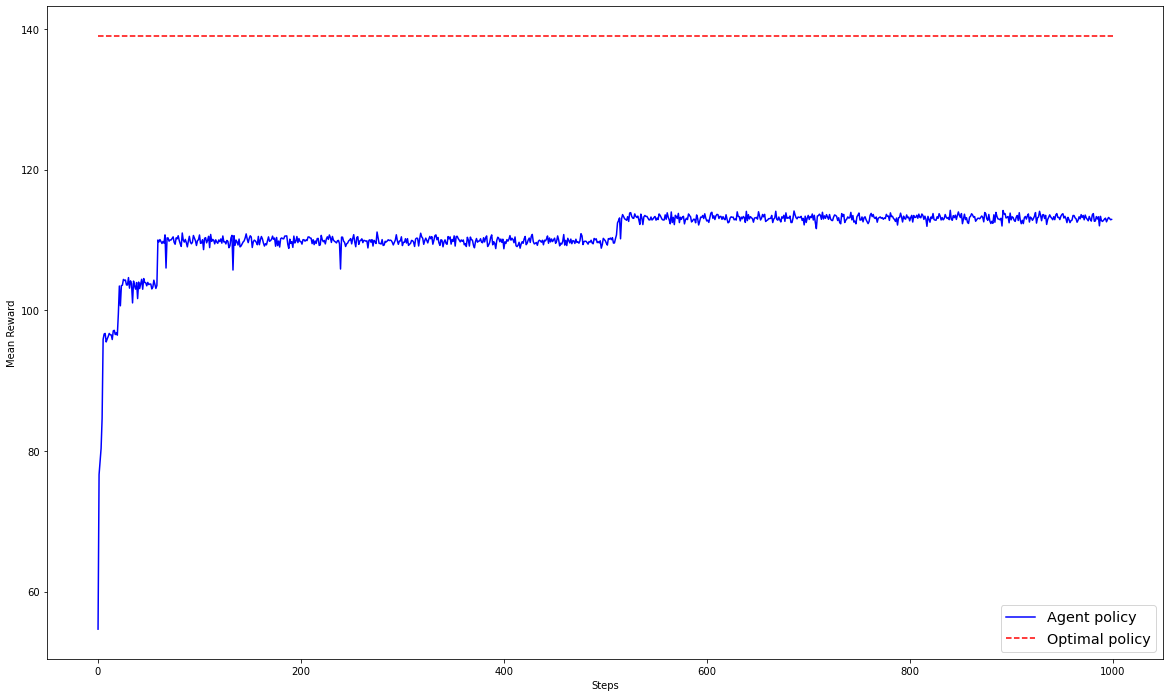

In [19]:
plot_mean_reward(mean_reward, optimal_reward)

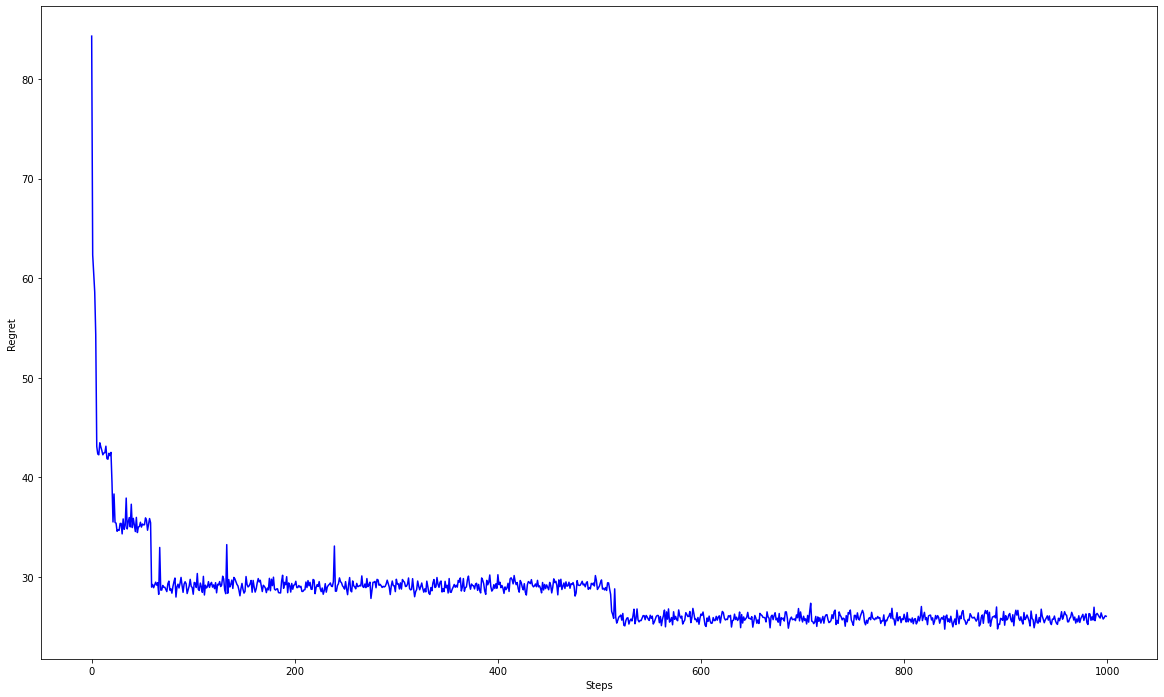

In [20]:
regrets = optimal_reward - mean_reward
plot_regret(regrets)

In [21]:
regret = np.sum(regrets)
regret

28162.707385568705

In [26]:
def mean_reward_diff_param(parameters):
    mr_list = []
    labels = []
    env = MutliArmedBanditEnvironment(rewards, 1000, '2')
    
    for parameter in parameters:
        rc_agent = ReinforcementComparisonBanditAgent('2', env, parameter[0], parameter[1], greedy=False)
        mean_reward = agent_run(rc_agent, env, 20, 1000)
        mr_list.append(mean_reward)
        labels.append('alpha: ' + str(parameter[0]) + ', beta: '+ str(parameter[1]))
        
    return mr_list, labels

In [27]:
def plot_mean_reward_diff_param(mr_list, labels):
    step_no = np.arange(len(mr_list[0]))
    plt.figure(figsize=(20, 12))

    
    for i, mr in enumerate(mr_list):
        plt.plot(step_no, mr, label=labels[i])
        
    plt.hlines(y = optimal_reward, xmin = 0, xmax = len(mean_reward), color = 'c', linestyle = '--', label='Optimal policy')

        
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    #plt.ylim([lower, upper])
    plt.legend(fontsize='x-large')
    plt.show();

C:\Users\Samin\Anaconda3\envs\Interactive\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
C:\Users\Samin\Anaconda3\envs\Interactive\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


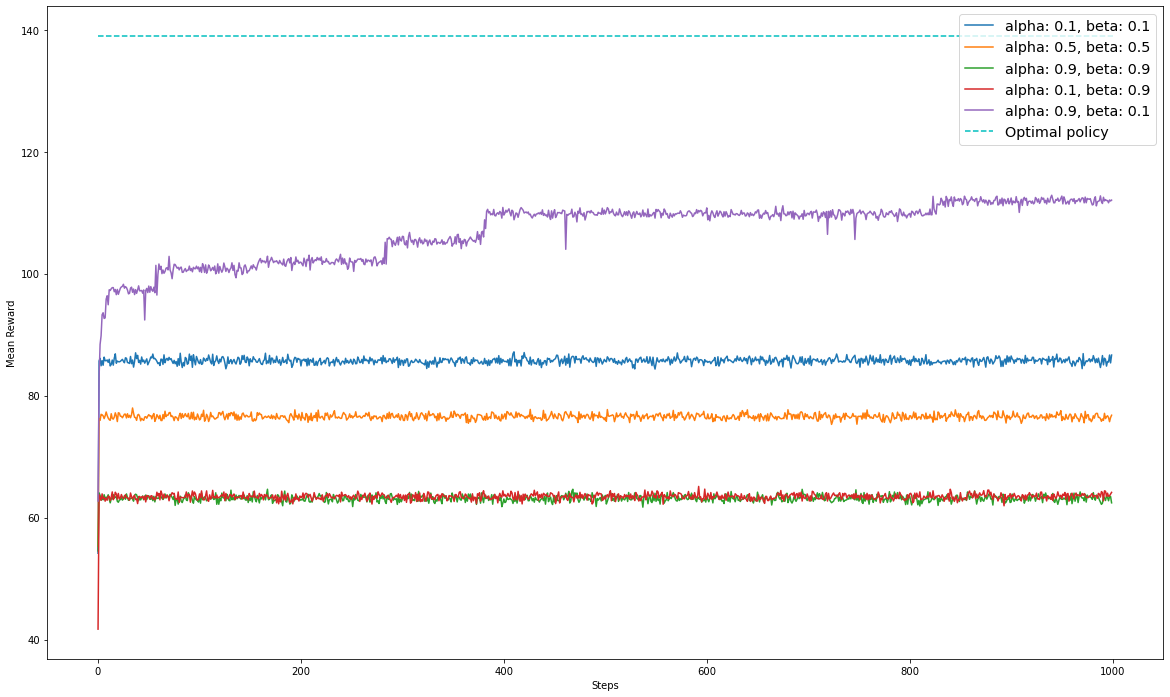

In [28]:
parameters = [[0.1, 0.1],
              [0.5, 0.5],
              [0.9, 0.9],
              [0.1, 0.9],
              [0.9, 0.1]]

mr_list, labels = mean_reward_diff_param(parameters)
plot_mean_reward_diff_param(mr_list, labels)

# c

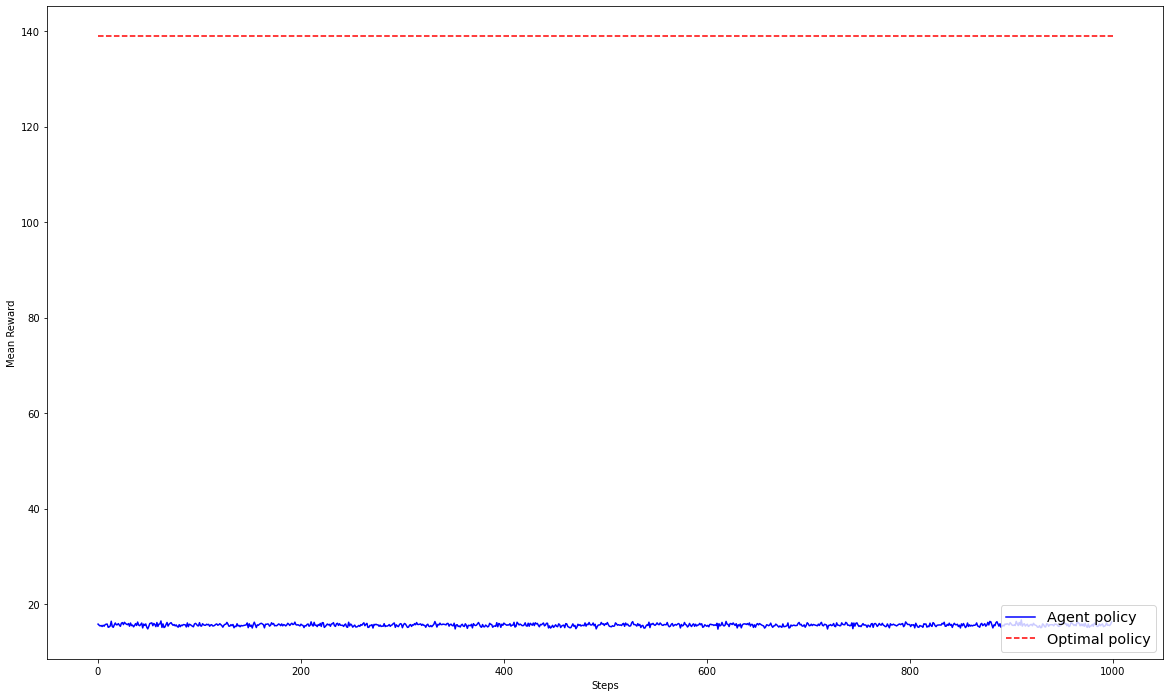

In [29]:
env = MutliArmedBanditEnvironment(rewards, 1000, '3')
rc_agent = ReinforcementComparisonBanditAgent('3', env, 0.9, 0.1, greedy=True)
mean_reward = agent_run(rc_agent, env, 20, 1000)
plot_mean_reward(mean_reward, optimal_reward)